In [1]:
#setup
import warnings; warnings.simplefilter('ignore')
%matplotlib notebook
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')

text = "Prof. Zurich hailed from Zurich. She got 3 M.A.'s from ETH."

In [2]:
###################################
# Splitting into sentences
###################################

from nltk import sent_tokenize
sentences = sent_tokenize(text) # split document into sentences
print(sentences)

['Prof. Milano hailed from Milano.', 'She got 3 M.A.', "'s from Bocconi."]


In [14]:
import spacy
nlp = spacy.load('en')
doc = nlp(text)
sentences = list(doc.sents)
print(sentences)

[Prof. Milano hailed from Milano., She got 3 M.A.'s from Bocconi.]


In [15]:
# Capitalization
text_lower = text.lower() # go to lower-case

In [16]:
#####
# Punctuation
#####

# recipe for fast punctuation removal
from string import punctuation
translator = str.maketrans('','',punctuation) 
text_nopunc = text_lower.translate(translator)
print(text_nopunc)

prof milano hailed from milano she got 3 mas from bocconi


In [17]:
# Tokens
tokens = text_nopunc.split() # splits a string on white space
print(tokens)

['prof', 'milano', 'hailed', 'from', 'milano', 'she', 'got', '3', 'mas', 'from', 'bocconi']


In [18]:
# Numbers
# remove numbers (keep if not a digit)
no_numbers = [t for t in tokens if not t.isdigit()]
# keep if not a digit, else replace with "#"
norm_numbers = [t if not t.isdigit() else '#' 
                for t in tokens ]
print(no_numbers )
print(norm_numbers)

['prof', 'milano', 'hailed', 'from', 'milano', 'she', 'got', 'mas', 'from', 'bocconi']
['prof', 'milano', 'hailed', 'from', 'milano', 'she', 'got', '#', 'mas', 'from', 'bocconi']


In [19]:
# Stopwords
from nltk.corpus import stopwords
stoplist = stopwords.words('english') 
# keep if not a stopword
nostop = [t for t in norm_numbers if t not in stoplist]
print(nostop)

['prof', 'milano', 'hailed', 'milano', 'got', '#', 'mas', 'bocconi']


In [20]:
# Stemming
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('german') # snowball stemmer, german
print(stemmer.stem("Autobahnen"))
stemmer = SnowballStemmer('english') # snowball stemmer, english
# remake list of tokens, replace with stemmed versions
tokens_stemmed = [stemmer.stem(t) for t in tokens]
print(tokens_stemmed)

autobahn
['prof', 'milano', 'hail', 'from', 'milano', 'she', 'got', '3', 'mas', 'from', 'bocconi']


In [7]:
# Lemmatizing
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
wnl.lemmatize('corporation'), wnl.lemmatize('corporations')

('corporation', 'corporation')

In [21]:
# Corpus statistics
df1 = pd.read_csv('death-penalty-cases.csv')
docs = df1['snippet']

print(len(sentences),'sentences in corpus.')
print(len(tokens),'words in corpus.')
words_per_sent = len(tokens) / len(sentences)
print(words_per_sent,'words per sentence.')

2 sentences in corpus.
11 words in corpus.
5.5 words per sentence.


In [22]:
# Bag of words representation
from collections import Counter
freqs = Counter(tokens)
freqs.most_common()[:20]

[('milano', 2),
 ('from', 2),
 ('prof', 1),
 ('hailed', 1),
 ('she', 1),
 ('got', 1),
 ('3', 1),
 ('mas', 1),
 ('bocconi', 1)]

In [8]:
# scikit-learn text vectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=10000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(df1['snippet'])
pd.to_pickle(X,'X.pkl')
vocabdict = vec.vocabulary_
vocab = [None] * len(vocabdict) 
for word,index in vocabdict.items():
    vocab[index] = word
pd.to_pickle(vocab,'vocab.pkl')

In [9]:
# tf-idf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=0.9,  # at most 90% of docs
                        max_features=1000,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(1,3))

X_tfidf = tfidf.fit_transform(df1['snippet'])
pd.to_pickle(X_tfidf,'X_tfidf.pkl')

<IPython.core.display.Javascript object>


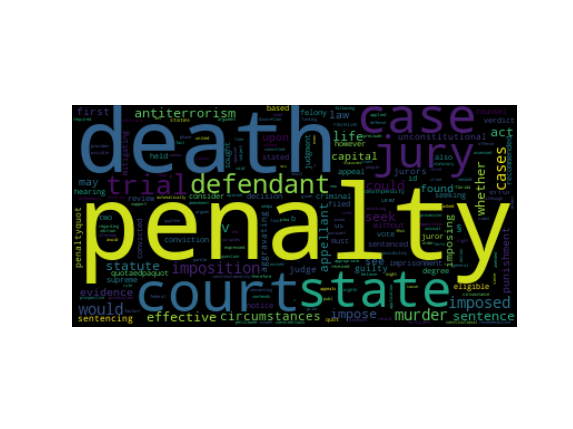

In [11]:
# Our first word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from txt_utils import get_docfreqs

# generate document counts for each word
f = get_docfreqs(df1['snippet']) 
# generate word cloud of words with highest counts
wordcloud = WordCloud().generate_from_frequencies(f) 

plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.show()

In [13]:
##########
# N-grams
#####
from nltk import ngrams
from collections import Counter

# get n-gram counts for 10 documents
grams = []
for i, row in df1.iterrows():
    tokens = row['snippet'].lower().split() # get tokens
    for n in range(2,4):
        grams += list(ngrams(tokens,n)) # get bigrams, trigrams, and quadgrams
    if i == 10:
        break
Counter(grams).most_common()[:8]  # most frequent n-grams

[(('death', 'penalty'), 38),
 (('the', 'death'), 34),
 (('the', 'death', 'penalty'), 25),
 (('death', 'penalty.'), 8),
 (('in', 'the'), 8),
 (('of', 'the'), 7),
 (('the', 'death', 'penalty.'), 6),
 (('(', ')'), 5)]

In [14]:
###
# Collocations: Point-Wise Mutual Information
###
from operator import mul
from functools import reduce
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def get_gmean(phrase, termfreqs):
    words = phrase.split('_')
    n = len(words)
    p = [termfreqs[w]**(1/n) for w in words]
    numerator = termfreqs[phrase]   
    denominator = reduce(mul, p)
    if denominator == 0:
        return 0
    gmean = numerator / denominator
    return gmean

In [18]:
#####
# POS tagging 
#####
text = 'Science cannot solve the ultimate mystery of nature. And that is because, in the last analysis, we ourselves are a part of the mystery that we are trying to solve.'

from nltk.tag import perceptron # need to run, nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize
tagger = perceptron.PerceptronTagger()
tokens = word_tokenize(text)
tagged_sentence = tagger.tag(tokens)
tagged_sentence

[('Science', 'NN'),
 ('can', 'MD'),
 ('not', 'RB'),
 ('solve', 'VB'),
 ('the', 'DT'),
 ('ultimate', 'JJ'),
 ('mystery', 'NN'),
 ('of', 'IN'),
 ('nature', 'NN'),
 ('.', '.'),
 ('And', 'CC'),
 ('that', 'DT'),
 ('is', 'VBZ'),
 ('because', 'RB'),
 (',', ','),
 ('in', 'IN'),
 ('the', 'DT'),
 ('last', 'JJ'),
 ('analysis', 'NN'),
 (',', ','),
 ('we', 'PRP'),
 ('ourselves', 'PRP'),
 ('are', 'VBP'),
 ('a', 'DT'),
 ('part', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('mystery', 'NN'),
 ('that', 'IN'),
 ('we', 'PRP'),
 ('are', 'VBP'),
 ('trying', 'VBG'),
 ('to', 'TO'),
 ('solve', 'VB'),
 ('.', '.')]

<IPython.core.display.Javascript object>


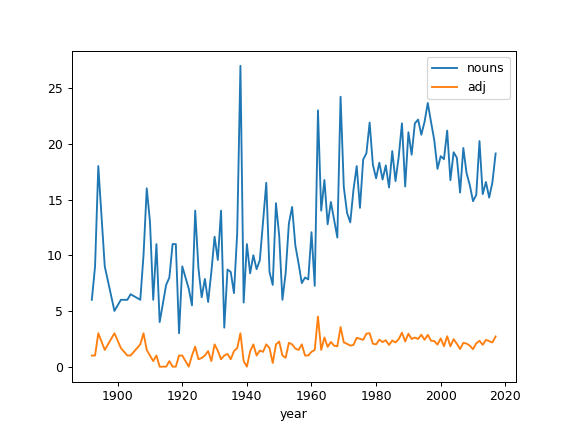

In [19]:
#####
# Our first visualization
# Plot nouns and adjectives over time
#####
from collections import Counter
from nltk import word_tokenize

def get_nouns_adj(snippet):
    tags = [x[1] for x in tagger.tag(word_tokenize(snippet))]
    num_nouns = len([t for t in tags if t[0] == 'N'])
    num_adj = len([t for t in tags if t[0] == 'J'])
    return num_nouns, num_adj

dfs = df1.sample(frac=.1)
dfs['nouns'], dfs['adj'] = zip(*dfs['snippet'].map(get_nouns_adj))
dfs.groupby('year')[['nouns','adj']].mean().plot()

In [20]:
# Get list of nouns, adjectives, and verbs from WordNet
from nltk import wordnet as wn
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
stop.add('well')

full_vocab = set()

for x in wn.wordnet.all_synsets('a'):
    full_vocab.add(x.lemma_names()[0].lower())
for x in wn.wordnet.all_synsets('n'):
    full_vocab.add(x.lemma_names()[0].lower())
for x in wn.wordnet.all_synsets('v'):
    full_vocab.add(x.lemma_names()[0].lower())

full_vocab = full_vocab - stop

pd.to_pickle(full_vocab,'full_vocab.pkl')

In [21]:
###
# POS-filtered N-grams
###
# Normalize Penn tags
tagdict = { 'NN':'N',
            'NNS':'N',
                                    
            'JJ':'A',
            'JJR':'A',
            'JJS':'A',
            'VBG':'A', # gerunds/participles treated like adjectives

            'RB':'A', # adverbs treated as adjectives
            'RBR':'A',
            'RBS':'A',
            'PDT':'A', # predeterminer            

            'VB':'V',
            'VBD':'V',
            'VBN':'V',
            'VBP':'V',
            'VBZ':'V',
            'MD': 'V', # modals treated as verbs
            'RP': 'V', # particles treated as verbs
            
            'DT':'D',
                        
            'IN':'P',
            'TO':'P',

            'CC': 'C'}

tagpatterns = {'A','N','V','P','C','D',
           'AN','NN', 'VN', 'VV', 
            #'NV',
            'VP',                                    
            'NNN','AAN','ANN','NAN','NPN',
            'VAN','VNN', 'AVN', 'VVN',
            'VPN', 'VDN', 
            #'ANV','NVV','VVV', 'NNV',
            'VVP','VAV','VVN',
            'NCN','VCV', 'ACA',  
            'PAN',
            'NCVN','ANNN','NNNN','NPNN', 'AANN' 'ANNN','ANPN','NNPN','NPAN', 
            'ACAN', 'NCNN', 'NNCN', 'ANCN', 'NCAN',
            'PDAN', 'PNPN',
            'VDNN', 'VDAN','VVDN'}

max_phrase_length = 4

termfreqs = Counter()

docs = pd.read_pickle('processed_corpus.pkl')

for i, doc in enumerate(docs.values()):
    if i > 2000:
        break
    for sentence in doc:    
        # split into words and get POS tags
        tagwords = []
        for (word,tag) in tagger.tag(sentence):
            if tag in tagdict:
                normtag = tagdict[tag]
                stemmed = word#stemmer.stem(word)
                tagwords.append((stemmed,normtag))
            else:
                tagwords.append(None)
        for n in range(1,max_phrase_length+1):            
            rawgrams = ngrams(tagwords,n)
            for rawgram in rawgrams:
                # skip grams that have rare words
                if None in rawgram:
                    continue
                gramtags = ''.join([x[1][0] for x in rawgram])
                if gramtags in tagpatterns:
                     # if tag sequence is allowed, add to counter
                    gram = '_'.join([x[0] for x in rawgram])
                    termfreqs[gram] += 1

# filter out unigrams
grams = [x for x in termfreqs.most_common() if '_' in x[0]]
# make dataframe of geometric mean associations for each gram
gmeans = pd.DataFrame([(gram[0], get_gmean(gram[0],termfreqs)) for gram in grams],
              columns=['ngram','gmean'])
gmeans.sort_values('gmean')

,ngram,gmean
10268,___,0.000000
9394,penalty_of_death,0.000144
8168,death_penalty_and_death,0.000159
8169,penalty_and_death_penalty,0.000159
8166,penalty_and_death,0.000179
5182,s_the_death_penalty,0.000196
7688,not_death_penalty,0.000206
11334,death_&_quot,0.000212
3927,has_the_death_penalty,0.000227
5181,s_the_death,0.000236
